# DCA Ingest
Dieses Notebook dient dem Einlesen, analysieren und exportieren von Daten des Digitalen Konstruktionsarchivs
Im ersten Schritt werden die Daten eines Verzeichnisses mithilfe von DROID analysiert.
Anschliessend können die Daten individuell analysiert werden.
Im letzten Schritt wird diese Analyse in RDF form festgehalten und zusammen mit den Metadaten des digitalen Materials exportiert.

## Imports und Setup

In [2]:
%pip install pandas matplotlib pywaffle seaborn rdflib ipywidgets
import os
import subprocess
import sys
import pandas as pd
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Konfiguration

Hier werden alle Pfade und Parameter definiert.

In [4]:
# Pfad zum Datenset definieren
project_path = "Keller/07_Plaene_Visualisierungen/01_Studie"
# Datenset (zu analysiernder Ordner) definieren
dataset_to_analyze = "00_Rhino-Daten"

# Dynamisches Home-Verzeichnis
home_dir = os.path.expanduser("~")
base_path = os.path.join(home_dir, "work")

# Pfade
droid_script_path = os.path.join(base_path, "27_DCA_Ingest/src/droid-binary-6.7.0-bin/droid.sh")
folder_to_analyze = os.path.join(base_path, f"dcaonnextcloud-500gb/DigitalMaterialCopies/{project_path}/{dataset_to_analyze}")
output_folder = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/{project_path}/{dataset_to_analyze}_results")
output_csv_path = os.path.join(output_folder, f"{dataset_to_analyze}_DROIDresults.csv")

# Pfad zu src/ hinzufügen, um lokale Module zu importieren
src_path = os.path.join(base_path, "27_DCA_Ingest/src")
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"Analyzing folder: {folder_to_analyze}")
print(f"Output will be saved to: {output_csv_path}")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/00_Rhino-Daten_DROIDresults.csv


## DROID-Analyse ausführen

Führt die DROID-Analyse auf dem konfigurierten Ordner aus.

In [5]:
try:
    # Output-Ordner erstellen (falls nicht vorhanden)
    os.makedirs(output_folder, exist_ok=True)

    print(f"Analyzing folder: {folder_to_analyze}")
    print(f"Output will be saved to: {output_csv_path}")

    # DROID-Skript ausführen mit "best match only"
    result = subprocess.run(
        [
            droid_script_path,
            "-R", folder_to_analyze,
            "-o", output_csv_path,
            "-Pr", "profile.generateHash=true",
            "-ff", "file_name not startswith ~$"
        ],
        check=True,
        capture_output=True,
        text=True
    )

    print("DROID output:", result.stdout)
    print(f"Analysis complete. The result is saved in {output_csv_path}.")

except subprocess.CalledProcessError as e:
    print(f"An error occurred while running DROID: {e}")
    print("DROID error output:", e.stderr)

except PermissionError as e:
    print(f"Permission error: {e}")
    print("Bitte prüfe, ob du Schreibrechte für den Zielordner hast.")

except FileNotFoundError as e:
    print(f"Datei oder Verzeichnis nicht gefunden: {e}")
    print("Bitte prüfe, ob alle Pfade korrekt sind und existieren.")

Analyzing folder: /home/renku/work/dcaonnextcloud-500gb/DigitalMaterialCopies/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten
Output will be saved to: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/00_Rhino-Daten_DROIDresults.csv
DROID output: 2025-11-14T08:17:01,587  INFO [main] DroidCommandLine:225 - Starting DROID.
2025-11-14T08:17:02,565  INFO [main] ProfileManagerImpl:129 - Creating profile: 1763108222565
2025-11-14T08:17:02,585  INFO [main] ProfileInstance:365 - Attempting state change [INITIALISING] to [VIRGIN]
2025-11-14T08:17:06,325  INFO [main] ProfileDiskAction:87 - Saving profile [/home/renku/.droid6/profiles/1763108222565/db] to [/home/renku/.droid6/profile_templates/schema 6.7.0/profile.template]
2025-11-14T08:17:10,771  INFO [main] ProfileDiskAction:87 - Saving profile [/home/renku/.droid6/profiles/1763108222565/db] to [/home/renku/.droid6/profile_templates/schema 6.7.0/profile.114.templ

## Erstellungsdatum hinzufügen

DROID liefert das letzte Änderungsdatum (LAST_MODIFIED), aber nicht das Erstellungsdatum.
Die folgende Zelle ergänzt die DROID-Ergebnisse mit dem Erstellungsdatum jeder Datei.

In [ ]:
# Erstellungsdatum zu DROID CSV hinzufügen
try:
    from add_creation_dates import add_creation_dates_to_csv
    
    print("Füge Erstellungsdaten zur DROID CSV hinzu...")
    df_with_creation = add_creation_dates_to_csv(
        input_csv=output_csv_path,
        output_csv=output_csv_path,  # Überschreibe die ursprüngliche Datei
        inplace=True
    )
    
    print("\nÜbersicht der Spalten nach Anreicherung:")
    print(df_with_creation.columns.tolist())
    
    # Zeige ein paar Beispielzeilen mit dem neuen CREATION_DATE Feld
    if 'CREATION_DATE' in df_with_creation.columns:
        print("\nBeispiel-Einträge mit Erstellungsdatum:")
        display_cols = ['NAME', 'LAST_MODIFIED', 'CREATION_DATE']
        available_cols = [col for col in display_cols if col in df_with_creation.columns]
        print(df_with_creation[available_cols].head())
    
except Exception as e:
    print(f"Fehler beim Hinzufügen der Erstellungsdaten: {e}")
    import traceback
    traceback.print_exc()

## Analyse der DROID-Ergebnisse

Die folgenden Zellen führen verschiedene Analysen auf den DROID-Ergebnissen durch.

In [6]:
# Pfade für die Analyse konfigurieren
# CSV_PATH: Pfad zur DROID-Ausgabe-CSV
if "output_csv_path" in locals():
    CSV_PATH = output_csv_path
else:
    # Fallback, falls output_csv_path nicht definiert wurde
    CSV_PATH = os.path.join(base_path, f"dcaonnextcloud-500gb/dca-metadataraw/Semiramis/{dataset_to_analyze}_results/analysis_result.csv")

# OUTPUT_DIR: Verzeichnis für Analyse-Ausgaben
OUTPUT_DIR = os.path.join(output_folder, "res")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"CSV-Datei für Analyse: {CSV_PATH}")
print(f"Ausgabeverzeichnis für Plots: {OUTPUT_DIR}")

CSV-Datei für Analyse: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/00_Rhino-Daten_DROIDresults.csv
Ausgabeverzeichnis für Plots: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/res


Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/res/format_counts.png


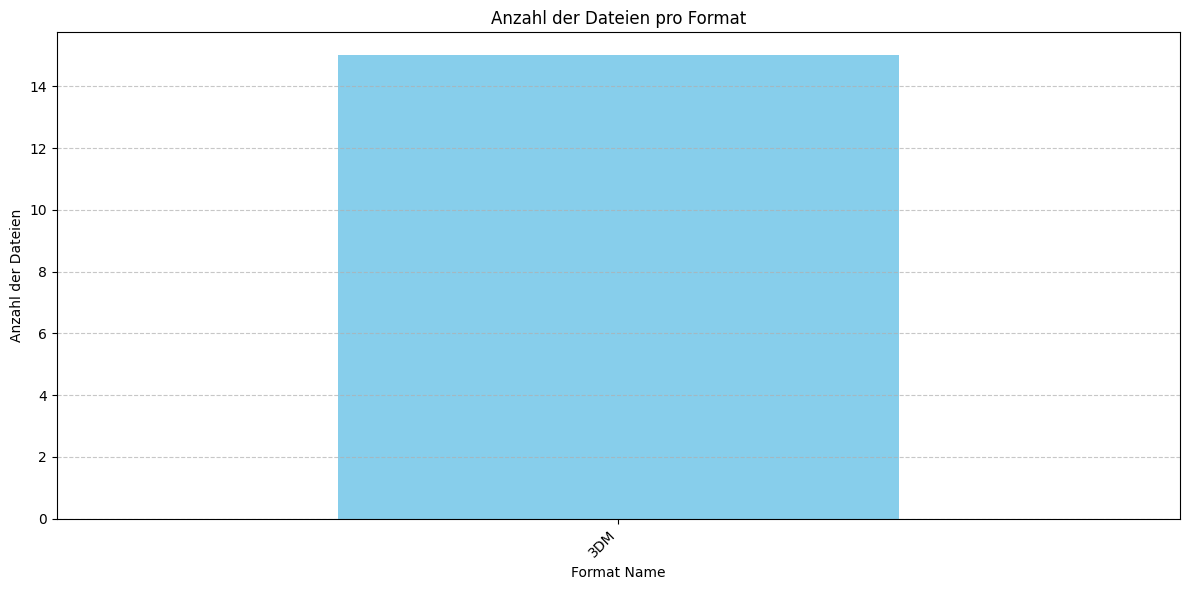

In [7]:
# Analyse: Anzahl der Dateien pro Format
try:
    from analyse_formats import analyse_formats
    analyse_formats(CSV_PATH, OUTPUT_DIR, show_plot=False)
except ImportError:
    print("Hinweis: analyse_formats Modul nicht gefunden. Überspringe diese Analyse.")
except FileNotFoundError as e:
    print(f"Datei nicht gefunden: {e}")
except Exception as e:
    print(f"Fehler bei analyse_formats: {e}")

Analysiere zeitliche Verteilung von: 3DM
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/res/3dm_time_series.png


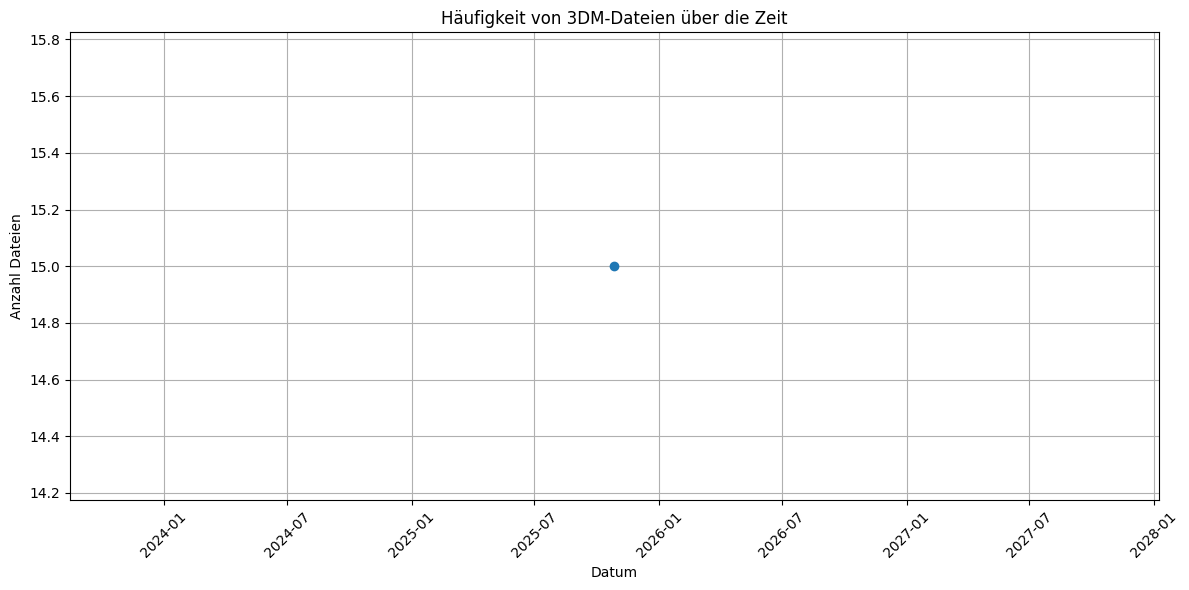

In [8]:
# Analyse: Zeitliche Verteilung eines spezifischen Formats
# Beispiel: Analysiere das häufigste Format über die Zeit
try:
    from analyse_format_over_time import analyse_format_over_time
    
    # Ermittle das häufigste Format
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        most_common_format = df["FORMAT_NAME"].value_counts().index[0]
        print(f"Analysiere zeitliche Verteilung von: {most_common_format}")
        analyse_format_over_time(CSV_PATH, most_common_format, OUTPUT_DIR, show_plot=False)
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError:
    print("Hinweis: analyse_format_over_time Modul nicht gefunden. Überspringe diese Analyse.")
except Exception as e:
    print(f"Fehler bei analyse_format_over_time: {e}")

Waffle-Chart für Zeitraum: 2025-2025
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Keller/07_Plaene_Visualisierungen/01_Studie/00_Rhino-Daten_results/res/waffle_files_per_month_2025_2025.png


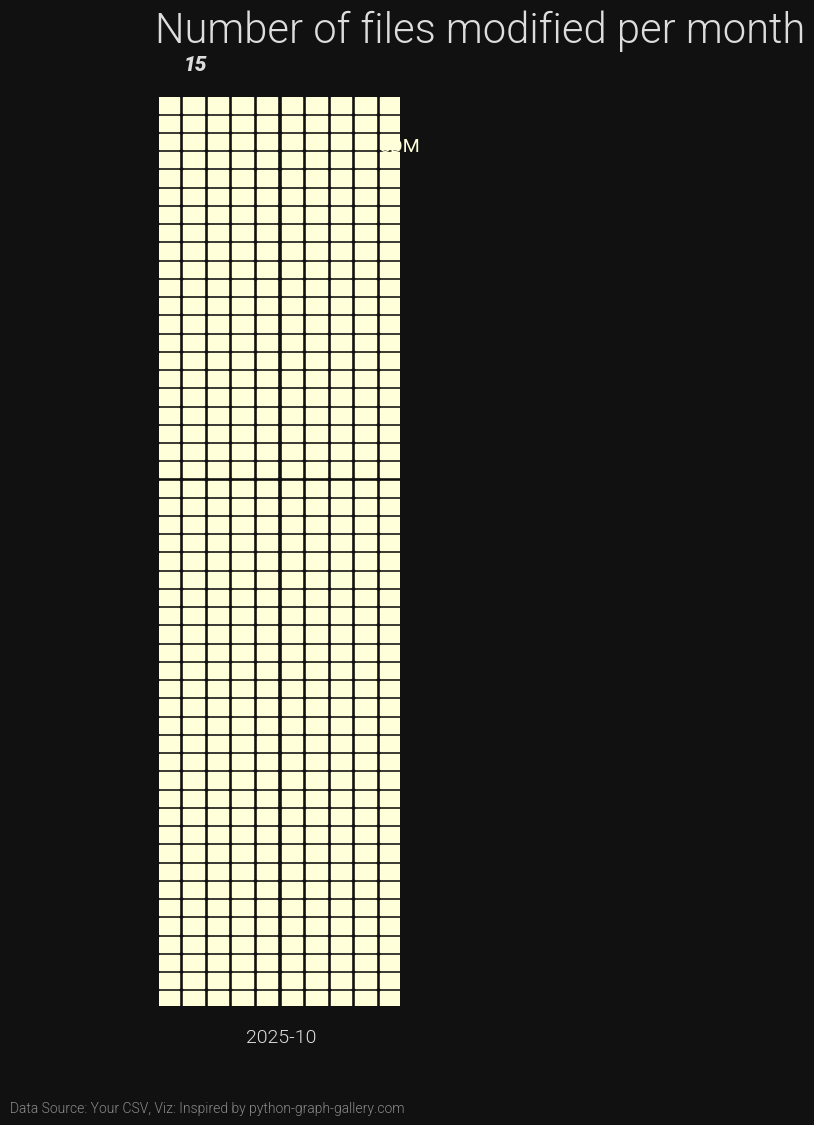

In [9]:
# Analyse: Waffle-Chart für monatliche Dateihäufigkeit
try:
    from generate_waffle import generate_waffle_chart
    
    # Ermittle den Zeitraum aus den Daten
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
        df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
        if len(df_clean) > 0:
            start_year = df_clean["LAST_MODIFIED"].dt.year.min()
            end_year = df_clean["LAST_MODIFIED"].dt.year.max()
            print(f"Waffle-Chart für Zeitraum: {start_year}-{end_year}")
            generate_waffle_chart(CSV_PATH, OUTPUT_DIR, start_year, end_year, top_n=10, show_plot=False)
        else:
            print("Keine gültigen Datumsangaben in den Daten gefunden.")
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError as e:
    print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Waffle-Chart.")
    print("Installieren Sie pywaffle falls benötigt: pip install pywaffle")
except Exception as e:
    print(f"Fehler bei generate_waffle_chart: {e}")

Heatmap für Zeitraum: 2021-2025
Plot gespeichert unter: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/res/heatmap_top10_formats_by_month_2021_2025.png


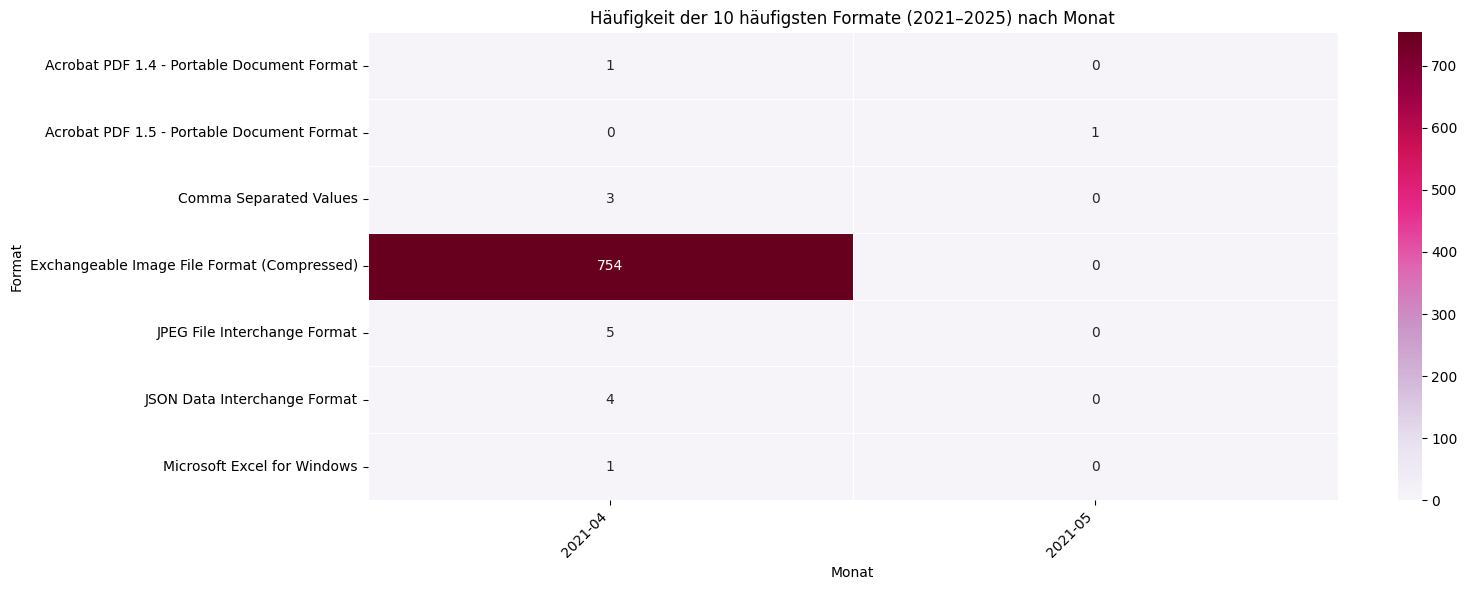

In [12]:
# Analyse: Heatmap der häufigsten Formate nach Monat
try:
    from analyse_format_heatmap import generate_format_heatmap
    
    # Ermittle den Zeitraum aus den Daten
    if os.path.exists(CSV_PATH):
        df = pd.read_csv(CSV_PATH)
        df["LAST_MODIFIED"] = pd.to_datetime(df["LAST_MODIFIED"], errors="coerce")
        df_clean = df.dropna(subset=["LAST_MODIFIED"])
        
        if len(df_clean) > 0:
            start_year = df_clean["LAST_MODIFIED"].dt.year.min()
            end_year = df_clean["LAST_MODIFIED"].dt.year.max()
            print(f"Heatmap für Zeitraum: {start_year}-{end_year}")
            generate_format_heatmap(CSV_PATH, OUTPUT_DIR, start_year, end_year, top_n=10, show_plot=False)
        else:
            print("Keine gültigen Datumsangaben in den Daten gefunden.")
    else:
        print(f"CSV-Datei nicht gefunden: {CSV_PATH}")
except ImportError as e:
    print(f"Hinweis: Modul nicht gefunden ({e}). Überspringe Heatmap.")
    print("Installieren Sie seaborn falls benötigt: pip install seaborn")
except Exception as e:
    print(f"Fehler bei generate_format_heatmap: {e}")

## Datenannotation und Export
Im letzten Schritt werden ausgewählte Daten aus der Analyse im RDF Format exportiert. Zusätzlich können Relationen zwischen den Daten erfasst werden.

In [8]:

# ============================================================================
# CRMdig File Relations Cell
# ============================================================================
# This cell provides interactive and programmatic tools for recording
# relations between files using CRMdigital (CRMdig) vocabulary.

# ============================================================================

# Import the CRMdig RDF module
# Add src path if not already in sys.path
if 'base_path' in locals():
    src_path = os.path.join(base_path, "27_DCA_Ingest/src")
else:
    src_path = os.path.join(os.path.expanduser("~"), "work/27_DCA_Ingest/src")

if src_path not in sys.path:
    sys.path.insert(0, src_path)

from crmdig_rdf import ensure_uids, build_graph_from_dataframe, add_relations_to_graph, save_graph, interactive_relation_builder

# ============================================================================
# Configuration
# ============================================================================

# Reuse CSV_PATH and OUTPUT_DIR from earlier cells
# (These should be defined in previous notebook cells)
if 'CSV_PATH' not in locals() or 'OUTPUT_DIR' not in locals():
    print("Warning: CSV_PATH and OUTPUT_DIR not found. Using defaults.")
    CSV_PATH = os.path.join(os.path.expanduser("~"), "work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/analysis_result.csv")
    OUTPUT_DIR = os.path.join(os.path.expanduser("~"), "work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/res")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set base namespace for RDF URIs
BASE_NS = "http://example.org/dca"

# Set output RDF file path
OUT_RDF = os.path.join(OUTPUT_DIR, "relations.ttl")

print(f"CSV Path: {CSV_PATH}")
print(f"Output RDF: {OUT_RDF}")
print(f"Base Namespace: {BASE_NS}")

# ============================================================================
# Step 1: Ensure Stable UIDs exist in CSV
# ============================================================================

print("\nEnsuring stable UIDs in CSV...")
df = ensure_uids(CSV_PATH, base_ns=BASE_NS, uid_column='uid', inplace=True)
print(f"✓ UIDs ensured for {len(df)} files")

# ============================================================================
# Step 2: Interactive Relation Builder (Jupyter UI)
# ============================================================================

# Uncomment the following line to launch the interactive UI:
interactive_relation_builder(CSV_PATH, OUT_RDF, base_ns=BASE_NS, uid_column='uid')

print("\nTo launch the interactive UI, uncomment the line above and run this cell.")

# ============================================================================
# Step 3: Programmatic Example (Alternative to Interactive UI)
# ============================================================================
# 
# If you prefer to create relations programmatically instead of using the UI,
# uncomment and modify the example below:
#
# # Build graph from CSV
# graph = build_graph_from_dataframe(df, base_ns=BASE_NS, uid_column='uid')
# print(f"Graph initialized with {len(graph)} triples")
#
# # Define relations between files
# # Example: File A is output of Process B, File C derives from File A
# relations = [
#     {
#         "subject_uid": "your-file-uid-1",  # Replace with actual UID from CSV
#         "object_uid": "your-file-uid-2",
#         "predicate": "is output of",
#         "label": "Converted from original scan"
#     },
#     {
#         "subject_uid": "your-file-uid-3",
#         "object_uid": "your-file-uid-1",
#         "predicate": "derives from",
#         "label": "Enhanced version"
#     },
# ]
#
# # Add relations to graph
# add_relations_to_graph(graph, relations, base_ns=BASE_NS)
# print(f"Added {len(relations)} relations to graph")
#
# # Save graph to file
# save_graph(graph, OUT_RDF, format='turtle')
# print(f"✓ Graph saved to: {OUT_RDF}")
#
# # Display some triples
# print("\nSample triples:")
# for i, (s, p, o) in enumerate(graph):
#     if i < 10:
#         print(f"  {s} -> {p} -> {o}")
#     else:
#         break

print("\n" + "="*70)
print("CRMdig Relations Cell Ready!")
print("Choose one:")
print("1. Uncomment interactive_relation_builder() line to use the UI")
print("2. Uncomment the programmatic example to create relations via code")
print("="*70)


CSV Path: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/analysis_result_2.csv
Output RDF: /home/renku/work/dcaonnextcloud-500gb/dca-metadataraw/Semiramis/2104_mockup_results/res/relations.ttl
Base Namespace: http://example.org/dca

Ensuring stable UIDs in CSV...
✓ UIDs ensured for 804 files



To launch the interactive UI, uncomment the line above and run this cell.

CRMdig Relations Cell Ready!
Choose one:
1. Uncomment interactive_relation_builder() line to use the UI
2. Uncomment the programmatic example to create relations via code
